# Likelihood contourf with the FGD with the light minimal model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from Likelihood import LEff, poissonLikelihood
from dark_nus_utils import load_datasets
from const import alphaQED
from parameters_dict import mass_material, fgd_mass, fgd_systematic_uncertainties, fgd_binning
from plot_utils import set_plot_title

In [3]:
hierarchy = 'light'
D_or_M = 'majorana'

In [4]:
save_folder = f'../fig/6_visualization/{hierarchy}_{D_or_M}/'
!mkdir -p $save_folder

In [5]:
levels = {0.68: -2.3/2,
          0.9: -4.61/2,
          0.95: -5.99/2}

In [6]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, fluxes=['FHC'], timeit=True, direct_load_objects=False, dump=False)

light majorana FHC
loading df base
initialising df base


/n/home00/nfoppiani/.conda/envs/dark_nus/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


loading df 0.01, 0.0075
initialising df 0.01, 0.0075
loading df 0.1, 0.0075
initialising df 0.1, 0.0075
loading df 0.1, 0.03
initialising df 0.1, 0.03
loading df 0.4, 0.0075
initialising df 0.4, 0.0075
loading df 0.4, 0.03
initialising df 0.4, 0.03
loading df 0.4, 0.1
initialising df 0.4, 0.1
loading df 0.8, 0.0075
initialising df 0.8, 0.0075
loading df 0.8, 0.03
initialising df 0.8, 0.03
loading df 0.8, 0.1
initialising df 0.8, 0.1
loading df 0.8, 0.4
initialising df 0.8, 0.4
Wall time: 88.88723397254944 s, CPU time: 74.21989138800001


In [7]:
def plot_likelihood_contour(likelihood, x_edges, y_edges, label_template='$m_4$ = {} GeV', linestyles=['-', '--', 'dotted'], ax=None):
    if ax is None:
        ax = plt.gca()
    contours = {}
    for i, (val, like) in enumerate(likelihood.items()):
        ax.contourf(x_edges, y_edges, like,
                                      levels=[-np.inf, like.max() + levels[0.9]], 
                                    colors=['orange'], alpha=0.15)
        contours[val] = ax.contour(x_edges, y_edges, like,
                                      levels=[-np.inf, like.max() + levels[0.9]], 
                                   colors=['chocolate'], linestyles=[linestyles[i]], alpha=0.5)
    ax.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
               [label_template.format(val) for val in contours.keys()],
               frameon=False,
               loc='lower right')

In [8]:
import parameters_dict
def light_ee_mass(my_exp_analysis, m4=0.1, mz=0.03, Umu4_2=8e-9, alpha_d=0.25, epsilon=1.7e-4, 
                               additional_factor=parameters_dict.ratio_fgd_mass_p0d_carbon*parameters_dict.fgd_efficiency):
    Vmu4_alpha_epsilon2 = alpha_d * Umu4_2 * alphaQED * epsilon**2
    this_mu = Vmu4_alpha_epsilon2/my_exp_analysis.Vmu4_alpha_epsilon2
    kde_weights, aux_df = my_exp_analysis.kde_n_events(df=my_exp_analysis.df_base.query('carbon'),
                                                     m4mz=(m4, mz),
                                                     ctau=None,
                                                     mu=this_mu,
                                                     return_df=True)
    return kde_weights*additional_factor, aux_df['ee_mass'], aux_df['ee_mass_reco']

def plot_with_signal(sidebands, exp_analyses, m4=0.1, mz=0.03, Umu4_2=8e-9, alpha_d=0.25, epsilon=1.7e-3):
    fig, axs = plt.subplots(1, len(sidebands), figsize=(5*len(sidebands), 5))
    if len(sidebands) == 1:
        axs = [axs]
    for sideband, exp_analysis, ax in zip(sidebands, exp_analyses, axs):
        data = digitized_data[sideband]    
        MCtot = digitized_MCtot[sideband]
        
        width = MCtot[1, 0] - MCtot[0, 0]
        
        ax.bar(MCtot[:, 0], MCtot[:, 1], 
               width=width,
               alpha=0.2, color='C0', label='total MC')
        
        syst = fgd_systematic_uncertainties[sideband]
        for i, (m, v) in enumerate(zip(MCtot[:, 0], MCtot[:, 1])):
            e = v * syst
            if i == 0:
                ax.add_patch(
                    patches.Rectangle(
                        (m - width/2, v - e),
                        width,
                        2 * e,
                        hatch="\\\\\\\\\\",
                        fill=False,
                        linewidth=0,
                        alpha=0.4,
                        label='systematics',
                    )
                )
            else:
                ax.add_patch(
                    patches.Rectangle(
                        (m - width/2, v - e),
                        width,
                        2 * e,
                        hatch="\\\\\\\\\\",
                        fill=False,
                        linewidth=0,
                        alpha=0.4,
                    )
                )
        
        kde_weights, ee_mass_true, ee_mass_reco = light_ee_mass(exp_analysis,
                                                                m4, mz, Umu4_2, 
                                                                alpha_d, epsilon, 
                                                                additional_factor=parameters_dict.ratio_fgd_mass_p0d_carbon*parameters_dict.fgd_efficiency)
        hist_ee_mass_true, _ = np.histogram(ee_mass_true, bins=fgd_binning, weights=kde_weights)
        hist_ee_mass_reco, _ = np.histogram(ee_mass_reco, bins=fgd_binning, weights=kde_weights)
        ax.step(MCtot[:, 0], MCtot[:, 1] + hist_ee_mass_true, where='mid', color='C1', label='signal true level')
        ax.step(MCtot[:, 0], MCtot[:, 1] + hist_ee_mass_reco, where='mid', color='C2', label='signal reco level')

        ax.errorbar(data[:, 0], data[:, 1], yerr=np.sqrt(data[:,1]), fmt='k.', label='data')

        ax.legend(frameon=False)
        ax.set_xlabel(r'$m_{e^+e^-}$ [GeV]')
        ax.set_xlim(0, 0.2)
        ax.set_ylabel(r'Number of entries')
        ax.set_title(sideband.replace('_', ' ') + f' leading, {exp_analysis.pot} POT')

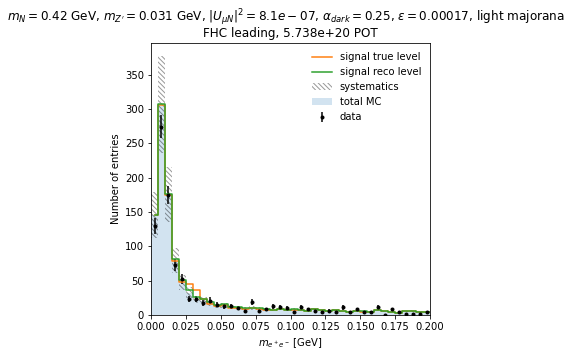

In [11]:
from posteriors import digitized_data, digitized_MCtot
this_pars = {
    'm4':0.42, 'mz':0.031, 'Umu4_2':(9e-4)**2, 'alpha_d':0.25, 'epsilon':1.7e-4
}

plot_with_signal(['FHC'], my_exp_analyses.values(), **this_pars)
set_plot_title(m4mz=(0.42, 0.031), exp_analysis_obj=my_exp_analyses['light_majorana_FHC'],
               kernel=None, smoothing_pars=None, suptitle=True, same_line=True, **this_pars)
# plt.savefig(save_folder + 'example_distribution.pdf')

In [57]:
light_simplified_posterior_two_sidebands(['FHC', 'RHC'], my_exp_analyses,
                                         systs={'FHC':0, 'RHC':0},
                                         n_observed=digitized_data, n_predicted_sm=digitized_MCtot,
                                         **this_pars)

-1800.4062345612178

In [44]:
light_simplified_posterior(my_exp_analyses['light_majorana_FHC'],
                           syst=0, binning=fgd_binning,
                           n_observed=digitized_data['FHC'][:, 1], n_predicted_sm=digitized_MCtot['FHC'][:, 1],
                           **this_pars)

-1202.7501219816045

In [45]:
light_simplified_posterior(my_exp_analyses['light_majorana_RHC'],
                           syst=0, binning=fgd_binning,
                           n_observed=digitized_data['RHC'][:, 1], n_predicted_sm=digitized_MCtot['RHC'][:, 1],
                           **this_pars)

-597.6561125796134

In [ ]:
fig, axs = plt.subplots(1, len(sidebands), figsize=(6*len(sidebands), 5))

plot_likelihood_contour(out[0], 
                        x_edges=np.linspace(0.005, 0.095, 10), 
                        y_edges=np.geomspace(1e-5, 1e-1, 15),
                        label_template='$m_4$ = {} GeV', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[0])
axs[0].loglog()
axs[0].set_xlabel(r'$m_z$ [GeV]')
axs[0].set_ylabel(r'$\epsilon$')

plot_likelihood_contour(out[1], 
                        x_edges=np.linspace(0.1, 1, 10), 
                        y_edges=np.geomspace(1e-10, 1e-1, 15),
                        label_template='$m_z$ = {} GeV', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[1])
axs[1].loglog()
axs[1].set_xlabel(r'$m_N$ [GeV]')
axs[1].set_ylabel(r'$|U_{\mu N}|^2$')

set_plot_title(exp_analysis_obj=my_exp_analyses['light_majorana_FHC'],
               kernel=None, smoothing_pars=None, suptitle=True, same_line=True, **this_pars)

# Check FHC, RHC, and both

In [15]:
mz_for_grid = np.linspace(0.005, 0.095, 10)
epsilon_for_grid = np.geomspace(1e-5, 1e-1, 15)
m4_for_grid = np.linspace(0.1, 1, 10)
Umu4_2_for_grid = np.geomspace(1e-10, 1e-1, 15)

base_pars = {
    'base_m4':0.1, 'base_mz':0.031, 'base_Umu4_2':(9e-4)**2, 'base_alpha_d':0.25, 'base_epsilon':1.7e-4
}

In [17]:
out = {}
out['FHC'] = compute_likelihoods_plane(sidebands=['FHC'], 
                                       exp_analyses=my_exp_analyses,
                                       m4_s=[base_pars['base_m4']],
                                       mz_for_grid=mz_for_grid,
                                       epsilon_for_grid=epsilon_for_grid,
                                       mz_s=[base_pars['base_mz']],
                                       m4_for_grid=m4_for_grid,
                                       Umu4_2_for_grid=Umu4_2_for_grid)

out['RHC'] = compute_likelihoods_plane(sidebands=['RHC'], 
                                       exp_analyses=my_exp_analyses,
                                       m4_s=[base_pars['base_m4']],
                                       mz_for_grid=mz_for_grid,
                                       epsilon_for_grid=epsilon_for_grid,
                                       mz_s=[base_pars['base_mz']],
                                       m4_for_grid=m4_for_grid,
                                       Umu4_2_for_grid=Umu4_2_for_grid)

out['FHC+RHC'] = ({key: out['FHC'][0][key] + out['RHC'][0][key] for key in out['FHC'][0].keys()},
                  {key: out['FHC'][1][key] + out['RHC'][1][key] for key in out['FHC'][1].keys()})

0.1
0 0.005
1 0.015
2 0.025
3 0.034999999999999996
4 0.045
5 0.055
6 0.065
7 0.07500000000000001
8 0.085
9 0.095
0.031
0 0.1
1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9
9 1.0
0.1
0 0.005
1 0.015
2 0.025
3 0.034999999999999996
4 0.045
5 0.055
6 0.065
7 0.07500000000000001
8 0.085
9 0.095
0.031
0 0.1
1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9
9 1.0


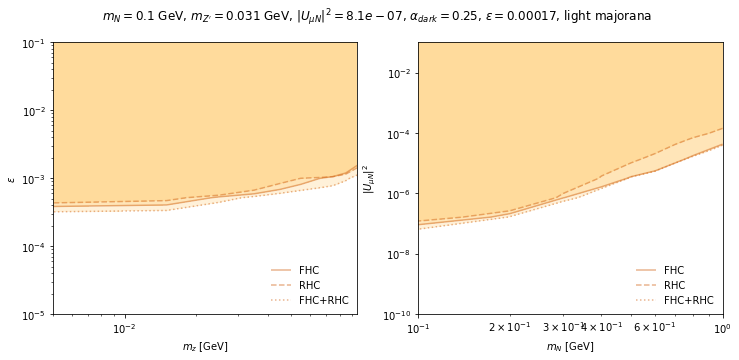

In [20]:
fig, axs = plt.subplots(1, len(sidebands), figsize=(6*len(sidebands), 5))

plot_likelihood_contour({key:list(value[0].values())[0] for key, value in out.items()}, 
                        x_edges=mz_for_grid, 
                        y_edges=epsilon_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[0])
axs[0].loglog()
axs[0].set_xlabel(r'$m_z$ [GeV]')
axs[0].set_ylabel(r'$\epsilon$')

plot_likelihood_contour({key:list(value[1].values())[0] for key, value in out.items()}, 
                        x_edges=m4_for_grid, 
                        y_edges=Umu4_2_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[1])
axs[1].loglog()
axs[1].set_xlabel(r'$m_N$ [GeV]')
axs[1].set_ylabel(r'$|U_{\mu N}|^2$')

set_plot_title(exp_analysis_obj=my_exp_analyses['light_majorana_FHC'],
               kernel=None, smoothing_pars=None, suptitle=True, same_line=True, 
               **{key.replace('base_', ''):value for key,value in base_pars.items()})

# Check syst and no syst

In [22]:
mz_for_grid = np.linspace(0.005, 0.095, 10)
epsilon_for_grid = np.geomspace(1e-5, 1e-1, 15)
m4_for_grid = np.linspace(0.1, 1, 10)
Umu4_2_for_grid = np.geomspace(1e-10, 1e-1, 15)

base_pars = {
    'base_m4':0.1, 'base_mz':0.031, 'base_Umu4_2':(9e-4)**2, 'base_alpha_d':0.25, 'base_epsilon':1.7e-4
}

In [23]:
out_syst = {}
out_syst['no_syst'] = compute_likelihoods_plane(sidebands=['FHC', 'RHC'],
                                       exp_analyses=my_exp_analyses,
                                       m4_s=[base_pars['base_m4']],
                                       mz_for_grid=mz_for_grid,
                                       epsilon_for_grid=epsilon_for_grid,
                                       mz_s=[base_pars['base_mz']],
                                       m4_for_grid=m4_for_grid,
                                       Umu4_2_for_grid=Umu4_2_for_grid,
                                       systs={'FHC':0, 'RHC':0})

out_syst['with_syst'] = compute_likelihoods_plane(sidebands=['FHC', 'RHC'],
                                       exp_analyses=my_exp_analyses,
                                       m4_s=[base_pars['base_m4']],
                                       mz_for_grid=mz_for_grid,
                                       epsilon_for_grid=epsilon_for_grid,
                                       mz_s=[base_pars['base_mz']],
                                       m4_for_grid=m4_for_grid,
                                       Umu4_2_for_grid=Umu4_2_for_grid)

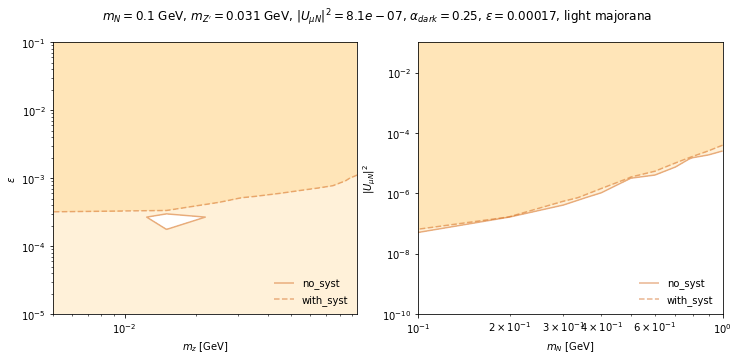

In [24]:
fig, axs = plt.subplots(1, len(sidebands), figsize=(6*len(sidebands), 5))

plot_likelihood_contour({key:list(value[0].values())[0] for key, value in out_syst.items()}, 
                        x_edges=mz_for_grid, 
                        y_edges=epsilon_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[0])
axs[0].loglog()
axs[0].set_xlabel(r'$m_z$ [GeV]')
axs[0].set_ylabel(r'$\epsilon$')

plot_likelihood_contour({key:list(value[1].values())[0] for key, value in out_syst.items()}, 
                        x_edges=m4_for_grid, 
                        y_edges=Umu4_2_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[1])
axs[1].loglog()
axs[1].set_xlabel(r'$m_N$ [GeV]')
axs[1].set_ylabel(r'$|U_{\mu N}|^2$')

set_plot_title(exp_analysis_obj=my_exp_analyses['light_majorana_FHC'],
               kernel=None, smoothing_pars=None, suptitle=True, same_line=True, 
               **{key.replace('base_', ''):value for key,value in base_pars.items()})
plt.savefig(

# Check no resolution, ee_true, ee_reco

In [22]:
mz_for_grid = np.linspace(0.005, 0.095, 10)
epsilon_for_grid = np.geomspace(1e-4, 1e-2, 15)
m4_for_grid = np.linspace(0.1, 1, 10)
Umu4_2_for_grid = np.geomspace(1e-8, 1e-4, 15)

base_pars = {
    'base_m4':0.1, 'base_mz':0.031, 'base_Umu4_2':(9e-4)**2, 'base_alpha_d':0.25, 'base_epsilon':1.7e-4
}

In [23]:
out_diff_resolutions = {}

for var in ('ee_mass_no_kde', 'ee_mass_reco', 'ee_mass_true'):
    print(var)
    out_diff_resolutions[var] = compute_likelihoods_plane(sidebands=['FHC', 'RHC'],
                                       exp_analyses=my_exp_analyses,
                                       m4_s=[base_pars['base_m4']],
                                       mz_for_grid=mz_for_grid,
                                       epsilon_for_grid=epsilon_for_grid,
                                       mz_s=[base_pars['base_mz']],
                                       m4_for_grid=m4_for_grid,
                                       Umu4_2_for_grid=Umu4_2_for_grid,
                                       signal_var=var)

ee_mass_no_kde


TypeError: kde_n_events() got an unexpected keyword argument 'return_df'

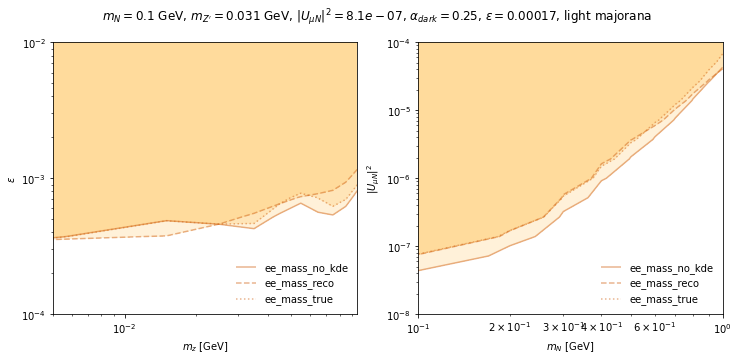

In [26]:
fig, axs = plt.subplots(1, len(sidebands), figsize=(6*len(sidebands), 5))

plot_likelihood_contour({key:list(value[0].values())[0] for key, value in out_diff_resolutions.items()}, 
                        x_edges=mz_for_grid, 
                        y_edges=epsilon_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[0])
axs[0].loglog()
axs[0].set_xlabel(r'$m_z$ [GeV]')
axs[0].set_ylabel(r'$\epsilon$')

plot_likelihood_contour({key:list(value[1].values())[0] for key, value in out_diff_resolutions.items()}, 
                        x_edges=m4_for_grid, 
                        y_edges=Umu4_2_for_grid,
                        label_template='{}', 
                        linestyles=['-', '--', 'dotted'],
                        ax=axs[1])
axs[1].loglog()
axs[1].set_xlabel(r'$m_N$ [GeV]')
axs[1].set_ylabel(r'$|U_{\mu N}|^2$')

set_plot_title(exp_analysis_obj=my_exp_analyses['light_majorana_FHC'],
               kernel=None, smoothing_pars=None, suptitle=True, same_line=True, 
               **{key.replace('base_', ''):value for key,value in base_pars.items()})
# plt.savefig(

# With external allowed regions and MiniBooNE ROI

In [12]:
from posteriors import light_minimal_posterior_v
import parameters_dict

In [13]:
m4_for_grid = np.linspace(0.0358, 1, 10)
Umu4_for_grid = np.geomspace(1e-5, 1e-2, 11)

m4, Umu4 = np.meshgrid(m4_for_grid, Umu4_for_grid)

base_pars = {
    'base_m4':0.1, 'base_mz':0.03, 'base_Umu4_2':(9e-4)**2, 'base_alpha_d':0.25, 'base_epsilon':1.7e-4
}

In [14]:
out_nd280_light = light_minimal_posterior_v(my_exp_analyses,
                                            fluxes=['FHC'],
                                            m4=m4, 
                                            mz=base_pars['base_mz'], 
                                            Umu4_2=Umu4**2, 
                                            alpha_d=base_pars['base_alpha_d'], 
                                            epsilon=base_pars['base_epsilon'],
                                            systs={'FHC':0, 'RHC':0},
                                            sensitivity=True,
                                            sensitivity_scale_factor=1)

In [15]:
out_nd280_light_sensitivity = light_minimal_posterior_v(my_exp_analyses,
                                                        fluxes=['FHC'],
                                            m4=m4,
                                            mz=base_pars['base_mz'], 
                                            Umu4_2=Umu4**2,
                                            alpha_d=base_pars['base_alpha_d'], 
                                            epsilon=base_pars['base_epsilon'],
                                            sensitivity=True,
                                            systs={'FHC':0, 'RHC':0})

Text(0.5, 0.98, 'No systematics')

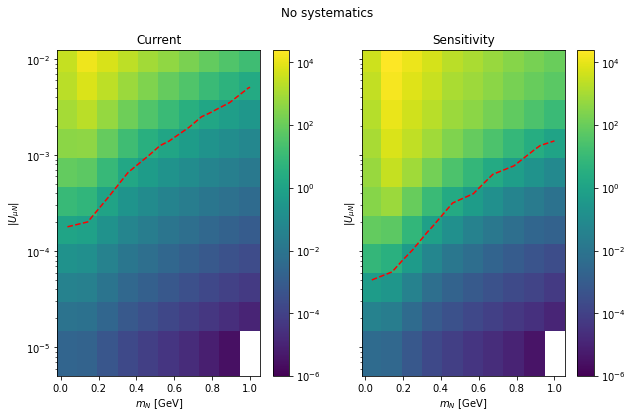

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

new_like = (-out_nd280_light[0]) - (-out_nd280_light[0]).min()
new_like_sensitivity = (-out_nd280_light_sensitivity[0]) - (-out_nd280_light_sensitivity[0]).min()
pcm = axs[0].pcolormesh(m4_for_grid, Umu4_for_grid, 
               new_like,
              shading='auto',
              norm=LogNorm(vmin=1e-6, vmax=new_like_sensitivity.max()))

axs[0].contour(m4_for_grid, Umu4_for_grid, new_like,
           levels=[-levels[0.9]], 
           colors=['red'], linestyles=['--'])

axs[0].set_yscale('log')
fig.colorbar(pcm, ax=axs[0])
axs[0].set_title('Current')
axs[0].set_xlabel('$m_N$ [GeV]')
axs[0].set_ylabel('$|U_{\mu N}|$')


pcm = axs[1].pcolormesh(m4_for_grid, Umu4_for_grid, 
               new_like_sensitivity,
              shading='auto',
              norm=LogNorm(vmin=1e-6, vmax=new_like_sensitivity.max()))

axs[1].contour(m4_for_grid, Umu4_for_grid, new_like_sensitivity,
           levels=[-levels[0.9]], 
           colors=['red'], linestyles=['--'])

axs[1].set_yscale('log')
fig.colorbar(pcm, ax=axs[1])
axs[1].set_title('Sensitivity')
axs[1].set_xlabel('$m_N$ [GeV]')
axs[1].set_ylabel('$|U_{\mu N}|$')

fig.suptitle('No systematics')

# previous iteration

In [17]:
out_nd280_light = light_minimal_posterior_v(my_exp_analyses,
                                            fluxes=['FHC'],
                                            m4=m4, 
                                            mz=base_pars['base_mz'], 
                                            Umu4_2=Umu4**2, 
                                            alpha_d=base_pars['base_alpha_d'], 
                                            epsilon=base_pars['base_epsilon'],
                                            )

In [18]:
out_nd280_light_sensitivity = light_minimal_posterior_v(my_exp_analyses,
                                                        fluxes=['FHC'],
                                                        m4=m4,
                                                        mz=base_pars['base_mz'], 
                                                        Umu4_2=Umu4**2,
                                                        alpha_d=base_pars['base_alpha_d'], 
                                                        epsilon=base_pars['base_epsilon'],
                                                        sensitivity=True,
                                                       )

<ipython-input-19-e3dbae8547f8>:84: UserWarning: The following kwargs were not used by contour: 'linestyle'
  Contour = ax.contour(xi, yi, zi, [4.61],\
<ipython-input-19-e3dbae8547f8>:84: UserWarning: The following kwargs were not used by contour: 'linestyle'
  Contour = ax.contour(xi, yi, zi, [4.61],\


(1e-05, 0.01)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


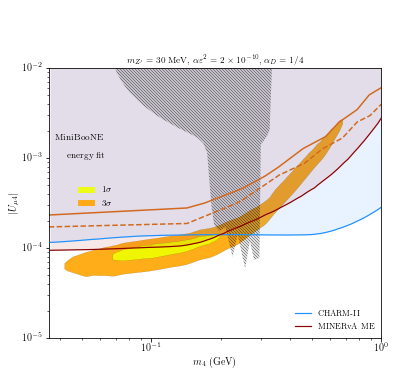

In [19]:
import numpy as np

from scipy import interpolate
import scipy.stats
from scipy.integrate import quad

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.colors as colors
import scipy.ndimage as ndimage

fsize = 10
S_GAUSS = 0.1
rc('text', usetex=True)
params={'axes.labelsize':fsize,
        'xtick.labelsize':fsize,
        'ytick.labelsize':fsize,
        'figure.figsize':(6, 5)}
        # 'figure.figsize':(3.39,1.2*2.3617)}
rc('font', **{'family':'serif', 'serif': ['computer modern roman']})
rcParams.update(params)
axes_form  = [0.18,0.16,0.77,0.75]

fig = plt.figure()
ax = fig.add_axes(axes_form)


ALPHA_FIT = 0.9

proxy2 = plt.Rectangle( (0,0), 1, 1, fc = "orange", ec=None, alpha=ALPHA_FIT, lw=0.7) 
proxy1 = plt.Rectangle( (0,0), 1, 1, fc = "#EFFF00", ec=None, alpha=ALPHA_FIT, lw=0.7) 

leg = ax.legend([proxy1,proxy2], [r"$1 \sigma$", r"$3 \sigma$"], fontsize=fsize*0.85, frameon=False, loc=(0.078, 0.470), ncol=1)
ax.add_artist(leg);
ax.annotate('MiniBooNE', xy=(0.038,0.0016), fontsize=0.9*fsize, color = 'black' )
ax.annotate('energy fit', xy=(0.043,0.001), fontsize=0.9*fsize, color = 'black' )

plt.setp(leg.get_title(),fontsize=fsize*0.85)
xu,yu = np.loadtxt("../digitized/Pedro_v3/upper_3_sigma.dat", unpack=True)
xl,yl = np.loadtxt("../digitized/Pedro_v3/low_3_sigma.dat", unpack=True)
x = np.logspace(np.log10(0.042), np.log10(0.68), 100)
up = np.interp(x,xu,yu)
low = np.interp(x,xl,yl)
ax.fill_between(x, np.sqrt(low),np.sqrt(up), facecolor='orange', lw=0.0, alpha=ALPHA_FIT, label=r'$3 \, \sigma$')
ax.fill_between(x, np.sqrt(low),np.sqrt(up), edgecolor='black', facecolor="None", lw=0.1, linestyle = '-', alpha=ALPHA_FIT, label=r'$3 \, \sigma$')

xu,yu = np.loadtxt("../digitized/Pedro_v3/upper_1_sigma.dat", unpack=True)
xl,yl = np.loadtxt("../digitized/Pedro_v3/low_1_sigma.dat", unpack=True)
x = np.logspace(np.log10(0.068), np.log10(0.21), 100)
up = np.interp(x,xu,yu)
low = np.interp(x,xl,yl)
ax.fill_between(x, np.sqrt(low),np.sqrt(up), facecolor='#EFFF00', lw=0.7, alpha=ALPHA_FIT, label=r'$1 \, \sigma$')
ax.fill_between(x, np.sqrt(low),np.sqrt(up), edgecolor='black', facecolor="None", lw=0.1, linestyle = '-', alpha=ALPHA_FIT, label=r'$1 \, \sigma$')
 
sensitivity_LE = np.load("../digitized/minerva_charm_limits/sensitivity_LE_vAugust2019.npy")
sensitivity_ME = np.load("../digitized/minerva_charm_limits/sensitivity_ME_vAugust2019.npy")
sensitivity_CH = np.load("../digitized/minerva_charm_limits/sensitivity_CH_vAugust2019.npy")
sensitivity_CH_bar = np.load("../digitized/minerva_charm_limits/sensitivity_CH_bar_vAugust2019.npy")

############################################################
# Plot fit
mheavy_LE, Umu42_LE, nevents_LE, chi2_LE = sensitivity_LE
mheavy_ME, Umu42_ME, nevents_ME, chi2_ME = sensitivity_ME
mheavy_CH, Umu42_CH, nevents_CH, chi2_CH = sensitivity_CH
mheavy_CH, Umu42_CH, nevents_CH_bar, chi2_CH_bar = sensitivity_CH_bar

chi2_CH = chi2_CH + chi2_CH_bar

Nint= 100
def plot_band(ax, mheavy, y, nevents, chi2, color_l, color, ls=1, alpha=0.1, label=''):
    mheavyl = np.log10(mheavy)
    yl = np.log10(y)
    xi = np.logspace(mheavyl.min(), mheavyl.max(), Nint)
    yi = np.logspace(yl.min(), yl.max(), Nint)

    zi = scipy.interpolate.griddata((mheavy, y), chi2,\
                                    (xi[None,:], yi[:,None]),\
                                    method='linear', fill_value="Nan", rescale=True)

    # zi_g = scipy.ndimage.filters.gaussian_filter(zi, 0.8, mode='nearest', order = 0, cval=0)
    # lw = 1.3
    Contour = ax.contour(xi, yi, zi, [4.61],\
                        colors=['None'], linewidths=0, linestyle=ls, alpha = alpha)

    l1 = Contour.collections[0].get_paths()[0].vertices  # grab the 1st path

    xint = np.logspace(-1.44, 0, 100)
    f1 = np.interp(xint, l1[:,0], l1[:,1])

    l, = ax.plot(xint, f1, color=color_l, ls='-', lw=1.2, zorder=5, label=label)
    ax.fill_between(xint, f1,np.ones(np.size(f1)), color=color, linewidth=0.0, alpha=alpha)
    return l


CHARM_COLOR = "dodgerblue"
CHARM_COLOR_L = "dodgerblue"

MINERVA_COLOR = "green"
MINERVA_COLOR_L = "darkgreen"

ME_COLOR = "firebrick"
ME_COLOR_L = "darkred"

l1 = plot_band(ax, mheavy_CH, np.sqrt(Umu42_CH), nevents_CH, chi2_CH, CHARM_COLOR_L, CHARM_COLOR, label = 'CHARM-II')
# plot_band(ax, mheavy_LE, np.sqrt(Umu42_LE), nevents_LE, chi2_LE, label, MINERVA_COLOR_L, MINERVA_COLOR)
l3 = plot_band(ax, mheavy_ME, np.sqrt(Umu42_ME), nevents_ME, chi2_ME, ME_COLOR_L, ME_COLOR, label = 'MINERvA ME')

ax.legend(frameon=False, handles=[l1,l3], fontsize=0.8*fsize, loc='lower right')
########################################
# Other model-indepenedent limits
ax.annotate(r"Excluded", xy=(0.12,0.04), fontsize=fsize, color = 'black' )
x,y = np.loadtxt("../digitized/Pedros_paper/experimental_constraints.dat", unpack=True)
ax.fill_between(x, np.sqrt(y), np.ones(np.size(y)), hatch='\\\\\\\\\\\\\\\\',facecolor='None', alpha=0.5, lw=0.0)
# ax.plot(x, np.sqrt(y), color='black', lw=0.5, hatch='///')

new_like = (-out_nd280_light[0]) - (-out_nd280_light[0]).min()
new_like_sensitivity = (-out_nd280_light_sensitivity[0]) - (-out_nd280_light_sensitivity[0]).min()

ax.contour(m4_for_grid, Umu4_for_grid, new_like,
           levels=[-levels[0.9]], 
           colors=['chocolate'], linestyles=['-'])

ax.contour(m4_for_grid, Umu4_for_grid, new_like_sensitivity,
           levels=[-levels[0.9]], 
           colors=['chocolate'], linestyles=['--'])
# plot_likelihood_contour(out_nd280_light[1], 
#                         x_edges=m4_for_grid, 
#                         y_edges=Umu4_for_grid,
#                         label_template='current T2K', 
#                         linestyles=['-'],
#                         ax=ax)

# plot_likelihood_contour(out_nd280_light_sensitivity[1], 
#                         x_edges=m4_for_grid, 
#                         y_edges=Umu4_for_grid,
#                         label_template='future T2K', 
#                         linestyles=['--'],
#                         ax=ax)

########################################
# TITLE
ax.set_title(r"$m_{Z^\prime} = 30$ MeV,  $\alpha\varepsilon^2= 2 \times 10^{-10}$,  $\alpha_D = 1/4$", fontsize=0.9*fsize)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$m_4$ (GeV)", fontsize=fsize)
ax.set_ylabel(r"$|U_{\mu4}|$", fontsize=fsize)

ax.set_xlim(0.0358,1.0)
ax.set_ylim(1e-5,0.01)

